In [9]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoModelForMaskedLM

from utils import *
from dataset import *
from preprocess import *
from wrapper import *
from models import *
from pipeline import PipelineGED

np.random.seed(1024)

device = torch.device("cpu")
# device = torch.device("cuda:0")
ntf()

In [11]:
MODEL_SIZE = 'base'
MODEL_ARCH = 'macbert'

In [13]:

np.random.seed(297)

train_df = pd.read_csv('../data/data-org/train.csv', sep='\t', index_col='id')
test_df = pd.read_csv('../data/data-org/test.csv', sep='\t', index_col='id')

oob_model_name = None
if MODEL_ARCH == 'ernie':
    model_name = 'nghuyong/ernie-gram-zh'
elif MODEL_ARCH == 'macbert':
    model_name = 'hfl/chinese-macbert-base' if MODEL_SIZE == 'base' else 'hfl/chinese-macbert-large'
elif MODEL_ARCH == 'roberta-word-based':
    model_name = 'uer/roberta-base-word-chinese-cluecorpussmall'
elif MODEL_ARCH == 'macbert+bert-wwm':
    model_name = 'hfl/chinese-macbert-base'
    oob_model_name = 'KoichiYasuoka/chinese-bert-wwm-ext-upos'
elif MODEL_ARCH == 'nezha':
    model_name = 'sijunhe/nezha-base-wwm'
else:
    raise NotImplementedError(f'Model {MODEL_ARCH} is not implemented yet.')


max_length = 128

test_dataset_config = {
    'model_name':model_name,
    'aux_model_name':oob_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':False, 
    'cut_all':False, 
}

test = DatasetWithAuxiliaryEmbeddings(df=test_df.reset_index(), **test_dataset_config)
test.tokenize()
test.construct_dataset()

train_dataset_config = {
    'model_name':model_name,
    'aux_model_name':oob_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':False, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':False, 
    'cut_all':False, 
}

train = DatasetWithAuxiliaryEmbeddings(df=train_df.reset_index(), **train_dataset_config)
train.tokenize()
train.construct_dataset()

ntf()

In [36]:
model_architecture = 'bert_with_clf_head'

if MODEL_ARCH == 'macbert':
    checkpoints = [
        '../finetuned_models/ensemble/macbert/model1/checkpoint-2278/pytorch_model.bin',
    ]
elif MODEL_ARCH == 'ernie':
    checkpoints = [f'../finetuned_models/balanced_trial_ernie_gram/fold{i}/checkpoint-1910/pytorch_model.bin' for i in range(10)] 
elif MODEL_ARCH == 'roberta-word-based':
    checkpoints = [
        "../finetuned_models/roberta_word_based/model4/checkpoint-2073/pytorch_model.bin", 
    ]
    model_architecture = 'bert_word_based'
elif MODEL_ARCH == 'macbert+bert-wwm':
    checkpoints = [
        "../finetuned_models/test_gen_data/model4/checkpoint-11935/pytorch_model.bin", 
    ]
elif MODEL_ARCH == 'nezha':
    checkpoints = ['../finetuned_models/nezha/model4/checkpoint-3440/pytorch_model.bin']
else:
    print(f'Model {MODEL_ARCH} is not implemented yet.')

data_configs = {
    'model_name':model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'split_words':False, 
    'cut_all':False, 
}
clf = PipelineGED(
    model_name=model_name, 
    oob_model_name=oob_model_name, 
    data_configs=data_configs, 
    pooling_mode='cls',  
    model_architecture=model_architecture, 
    hidden_layer_size=max_length, 
)

def apply_ged_pipeline_oob(texts, checkpoints=checkpoints, majority_vote=False):
    probs = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False)
    return probs


Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Eval on train set

In [4]:
data = train_df[['label', 'text']]

precision, recall, f1, accuracy = [], [], [], []

for cp in checkpoints:
    probs = apply_ged_pipeline_oob(texts=data.text.values, checkpoints=[cp], )[0]
    pred = probs.argmax(1)

    fp = ((data.label == 0).values * (pred==1)).sum()
    fn = ((data.label == 1).values * (pred==0)).sum()
    tp = ((data.label == 1).values * (pred==1)).sum()
    tn = ((data.label == 0).values * (pred==0)).sum()

    prec, rec = tp / (tp+fp), tp / (tp+fn)
    precision.append(prec)
    recall.append(rec)
    f1.append(2*prec*rec / (prec+rec))
    accuracy.append((tp+tn) / (tp+tn+fp+fn))

    ntf()

KeyboardInterrupt: 

In [ ]:
order = np.argsort(f1) + 1
props = order / order.sum()
props

array([1.])

In [ ]:
data = train_df[['label', 'text']]
data['prediction'] = pred
data['score'] = probs[:, 1]
data['confidence'] = 1 - 2*np.abs(data.score.values - data.prediction)
data = data[['label', 'prediction', 'score', 'confidence', 'text']]
print(len(data[data.label != data.prediction]))

with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

7628


label  prediction     score  confidence  \
id                                               
9          1           0  0.058370    0.883261   
20         1           0  0.255834    0.488332   
21         0           1  0.943100    0.886201   
43         1           0  0.089232    0.821536   
48         1           0  0.079518    0.840964   
49         1           0  0.066054    0.867891   
51         1           0  0.137150    0.725700   
58         1           0  0.073827    0.852347   
70         1           0  0.276161    0.447678   
79         1           0  0.065424    0.869153   
101        0           1  0.938687    0.877375   
102        1           0  0.072149    0.855701   
106        0           1  0.925548    0.851096   
109        1           0  0.171201    0.657598   
111        1           0  0.275285    0.449431   
113        0           1  0.937716    0.875432   
122        1           0  0.117467    0.765066   
126        1           0  0.073141    0.853718   
131        1           0  0.061212    0.877577   
134        0           1  0.942781    0.885562   
137        1           0  0.146219    0.707563   
144        0           1  0.952838    0.905676   
153        1           0  0.089878    0.820244   
155        1           0  0.176445    0.647110   
157        0           1  0.814187    0.628373   
158        0           1  0.915878    0.831756   
161        1           0  0.280699    0.438603   
171        1           0  0.084982    0.830036   
176        1           0  0.427190    0.145621   
179        1           0  0.123010    0.753979   
190        1           0  0.161326    0.677348   
201        0           1  0.719919    0.439838   
212        1           0  0.338822    0.322356   
213        1           0  0.381067    0.237866   
217        1           0  0.084299    0.831402   
219        1           0  0.111116    0.777767   
226        1           0  0.071846    0.856309   
240        1           0  0.409678    0.180643   
241        1           0  0.053041    0.893919   
257        1           0  0.073071    0.853858   
260        0           1  0.948903    0.897807   
262        1           0  0.256017    0.487966   
265        0           1  0.947708    0.895416   
270        0           1  0.913206    0.826411   
273        1           0  0.057993    0.884013   
276        1           0  0.079191    0.841618   
280        1           0  0.306790    0.386420   
301        1           0  0.072833    0.854334   
316        0           1  0.930860    0.861719   
322        1           0  0.487216    0.025568   
332        1           0  0.083612    0.832775   
334        1           0  0.084339    0.831321   
337        0           1  0.936989    0.873977   
343        1           0  0.077284    0.845432   
346        0           1  0.823520    0.647041   
348        1           0  0.065961    0.868078   
350        0           1  0.926660    0.853320   
358        1           0  0.060875    0.878250   
376        1           0  0.079102    0.841796   
378        1           0  0.072156    0.855687   
384        1           0  0.303480    0.393040   
401        1           0  0.052737    0.894527   
409        1           0  0.051767    0.896466   
411        1           0  0.076115    0.847771   
417        1           0  0.078857    0.842286   
418        1           0  0.101824    0.796353   
420        1           0  0.124154    0.751691   
426        1           0  0.102920    0.794161   
429        1           0  0.208457    0.583085   
442        0           1  0.891604    0.783208   
443        0           1  0.876099    0.752197   
446        0           1  0.918842    0.837683   
447        1           0  0.084318    0.831364   
450        1           0  0.100837    0.798326   
456        1           0  0.061076    0.877849   
477        1           0  0.385383    0.229235   
479        1           0  0.087285    0.825431   
487        1           0  0.075151    0.849697   
495    

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 200
    display(data)

label  prediction     score  confidence  \
id                                             
1        1           1  0.973615    0.947229   
2        1           1  0.956707    0.913414   
3        1           1  0.934584    0.869168   
4        1           1  0.954878    0.909756   
5        1           1  0.988399    0.976798   
6        1           1  0.883658    0.767316   
7        0           0  0.026919    0.946162   
8        1           0  0.049353    0.901294   
9        1           0  0.457989    0.084023   
10       1           1  0.548413    0.096827   
11       0           0  0.053106    0.893788   
12       1           1  0.966669    0.933338   
13       1           1  0.972772    0.945543   
14       0           0  0.047548    0.904904   
15       0           0  0.024592    0.950815   
16       1           1  0.979716    0.959432   
17       0           0  0.275093    0.449815   
18       0           0  0.075270    0.849461   
19       0           0  0.008702    0.982596   
20       1           0  0.044051    0.911898   
21       0           1  0.928950    0.857901   
22       1           1  0.959826    0.919651   
23       1           1  0.978773    0.957547   
24       1           1  0.634329    0.268658   
25       1           1  0.988104    0.976208   
26       1           1  0.975452    0.950904   
27       0           0  0.029710    0.940581   
28       1           1  0.949758    0.899517   
29       0           0  0.033832    0.932337   
30       1           0  0.332006    0.335988   
31       1           1  0.965642    0.931283   
32       1           1  0.991140    0.982279   
33       0           0  0.007868    0.984265   
34       0           0  0.019378    0.961245   
35       0           0  0.070784    0.858432   
36       1           1  0.982168    0.964335   
37       1           0  0.122483    0.755033   
38       0           0  0.018646    0.962708   
39       1           1  0.939278    0.878556   
40       1           1  0.981330    0.962661   
41       1           1  0.972235    0.944470   
42       1           1  0.903150    0.806300   
43       1           1  0.914872    0.829743   
44       0           0  0.090054    0.819892   
45       1           1  0.971257    0.942514   
46       1           1  0.846152    0.692303   
47       1           1  0.905299    0.810597   
48       1           0  0.055168    0.889664   
49       1           0  0.104368    0.791263   
50       1           1  0.770525    0.541050   
51       1           1  0.841299    0.682597   
52       0           0  0.017601    0.964797   
53       1           1  0.986606    0.973213   
54       1           1  0.931616    0.863232   
55       1           1  0.652901    0.305803   
56       1           0  0.038414    0.923172   
57       1           1  0.987424    0.974847   
58       1           0  0.071791    0.856419   
59       1           1  0.695698    0.391395   
60       1           0  0.439438    0.121124   
61       1           1  0.970313    0.940626   
62       1           1  0.923639    0.847278   
63       1           1  0.934530    0.869061   
64       1           1  0.944035    0.888070   
65       1           1  0.929772    0.859545   
66       0           0  0.041659    0.916682   
67       1           1  0.941841    0.883682   
68       1           1  0.644496    0.288992   
69       1           1  0.981254    0.962507   
70       1           0  0.435111    0.129779   
71       1           0  0.219404    0.561191   
72       1           1  0.986273    0.972547   
73       1           0  0.239317    0.521366   
74       0           0  0.017465    0.965070   
75       1           1  0.732848    0.465696   
76       0           0  0.462878    0.074243   
77       1           1  0.951685    0.903371   
78       1           1  0.947025    0.894050   
79       1           1  0.700082    0.400164   
80       0           0  0.023558    0.952885   
81       1           1  0.955807    0.911614   
82       1           

### Eval on Test Set

In [37]:
test_df = pd.read_csv('../data/data-org/test.csv', delimiter='\t').set_index('id')

In [38]:
# probs = torch.zeros((len(test_df), 2))

# checkpoints = [
#     "../finetuned_models/gen_data/model4/checkpoint-4760/pytorch_model.bin", 
# ]

# for p, cp in zip(props, checkpoints):
#     single_model_probs = apply_ged_pipeline_oob(texts=test_df.text.values, checkpoints=[cp], )[0]
#     probs += single_model_probs * p

In [39]:
probs = apply_ged_pipeline_oob(texts=test_df.text.values, checkpoints=checkpoints, )

100%|██████████| 65/65 [02:25<00:00,  2.24s/it]


In [41]:
data = test_df.copy(deep=True)
data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

data['pred'] = probs[0].argmax(1)
data['pred_score'] = probs[0][:, 1]
# pred_df = pd.read_csv('../submissions-aug/submission.csv', delimiter='\t')
# pred_df['id'] = range(1, 1+len(pred_df))
# pred_df.set_index('id', inplace=True)
# data['prediction'] = pred_df.label

data = data[['comp', 'pred', 'pred_score', 'text']]
print(len(data[data.comp != data.pred]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data.comp != data.pred])

230


comp  pred  pred_score  \
id                             
8        0     1    0.515003   
13       1     0    0.277627   
18       0     1    0.762588   
24       1     0    0.386413   
25       1     0    0.395846   
29       1     0    0.236943   
36       0     1    0.895664   
42       0     1    0.691718   
46       0     1    0.536172   
53       1     0    0.328638   
57       1     0    0.413589   
58       1     0    0.217690   
65       1     0    0.391708   
76       1     0    0.414731   
78       1     0    0.430487   
83       0     1    0.932266   
85       0     1    0.511608   
91       1     0    0.467610   
98       1     0    0.365778   
100      1     0    0.440079   
101      1     0    0.457623   
104      1     0    0.459915   
105      1     0    0.444962   
108      1     0    0.347959   
109      1     0    0.407486   
118      1     0    0.372551   
122      1     0    0.381183   
127      1     0    0.363936   
129      1     0    0.455922   
142      0     1    0.643852   
155      0     1    0.730580   
156      1     0    0.456846   
161      1     0    0.470294   
163      1     0    0.329371   
165      1     0    0.305420   
168      1     0    0.255153   
183      1     0    0.243255   
192      1     0    0.473469   
193      1     0    0.258527   
194      1     0    0.433941   
198      0     1    0.567795   
200      1     0    0.451590   
204      1     0    0.498371   
210      0     1    0.721538   
220      1     0    0.452749   
221      1     0    0.352880   
223      0     1    0.612045   
224      1     0    0.362669   
231      1     0    0.428657   
233      1     0    0.381457   
239      1     0    0.460621   
241      1     0    0.412118   
242      0     1    0.799624   
248      1     0    0.269682   
249      1     0    0.448312   
251      1     0    0.486798   
257      0     1    0.579302   
259      1     0    0.390837   
260      0     1    0.773482   
267      1     0    0.461000   
269      0     1    0.621287   
271      0     1    0.509089   
278      1     0    0.301574   
280      1     0    0.494292   
293      1     0    0.239010   
298      1     0    0.332214   
299      1     0    0.364592   
307      0     1    0.548586   
329      1     0    0.370822   
335      0     1    0.553153   
344      0     1    0.742164   
346      1     0    0.357824   
350      1     0    0.475192   
355      0     1    0.604848   
365      0     1    0.558803   
373      1     0    0.419713   
374      0     1    0.562695   
375      0     1    0.561006   
377      1     0    0.442317   
379      1     0    0.392004   
381      1     0    0.409718   
384      0     1    0.687885   
387      0     1    0.669394   
395      1     0    0.295171   
398      1     0    0.382349   
404      0     1    0.566042   
409      1     0    0.353017   
412      1     0    0.317829   
415      1     0    0.418393   
422      1     0    0.400424   
427      1     0    0.349271   
430      1     0    0.439635   
431      1     0    0.277558   
432      1     0    0.462184   
441      1     0    0.480853   
443      1     0    0.474917   
445      1     0    0.450909   
446      1     0    0.479144   
452      0     1    0.736298   
459      0     1    0.575533   
461      1     0    0.425298   
467      1     0    0.380867   
472      0     1    0.828501   
480      1     0    0.411351   
487      1     0    0.483343   
489      1     0    0.332480   
490      1     0    0.284441   
491      0     1    0.527885   
495      1     0    0.430397   
498      0     1    0.524523   
500      1     0    0.343807   
520      0     1    0.543003   
521      1     0    0.337826   
522      0     1    0.527500   
525      1     0    0.361453   
526      1     0    0.374966   
528      0     1    0.528679   
532      1     0    0.450431   
533      1     0    0.399282   
534      0     1    0.526015   
548      1     0    0.474756   
551      1     0    0.450397   
554      1     0    0.492221   
560   

In [19]:
submission = pd.DataFrame(data.pred)
submission = submission.rename(columns={'pred':'label'})
submission.to_csv('../submissions/submission.csv', sep='\t')

In [8]:
test_probs, test_seq_probs, test_err_char_lst = apply_ged_pipeline(test_df.text.values)
ntf()

100%|██████████| 65/65 [01:00<00:00,  1.08it/s]


In [10]:
test_data = test_df.copy(deep=True)
test_data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

test_data['prediction'] = test_probs.argmax(1)
test_data['score'] = test_probs[:, 1]
test_data['confidence'] = 1 - 2*np.abs(test_data.score.values - test_data.prediction)

test_data = test_data[['comp', 'prediction',  'score', 'confidence', 'text']]
# test_data['error_chars'] = test_err_char_lst
print(len(test_data[test_data.comp != test_data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # display(data[data.comp != data.prediction].sort_values(by='confidence'))
    display(test_data[test_data.comp != test_data.prediction])

263


comp  prediction     score  confidence  \
id                                             
8        0           1  0.532095    0.064190   
13       1           0  0.197834    0.604331   
18       0           1  0.659339    0.318678   
22       0           1  0.538983    0.077967   
25       1           0  0.243301    0.513399   
29       1           0  0.185317    0.629366   
42       0           1  0.704336    0.408671   
57       1           0  0.425843    0.148313   
58       1           0  0.388398    0.223203   
63       0           1  0.600122    0.200244   
72       1           0  0.434399    0.131201   
76       1           0  0.423113    0.153775   
83       0           1  0.690285    0.380569   
84       1           0  0.394654    0.210691   
88       0           1  0.553603    0.107207   
91       1           0  0.205744    0.588513   
95       1           0  0.200740    0.598521   
96       0           1  0.768431    0.536862   
100      1           0  0.356100    0.287800   
101      1           0  0.487307    0.025386   
115      1           0  0.318273    0.363454   
116      1           0  0.287550    0.424900   
118      1           0  0.428488    0.143024   
127      1           0  0.477820    0.044360   
131      1           0  0.470932    0.058135   
133      1           0  0.440309    0.119382   
142      0           1  0.521248    0.042495   
145      0           1  0.584007    0.168014   
154      0           1  0.624485    0.248970   
155      0           1  0.672890    0.345779   
163      1           0  0.205761    0.588478   
164      0           1  0.662004    0.324008   
165      1           0  0.247536    0.504927   
169      0           1  0.599816    0.199633   
175      0           1  0.646156    0.292312   
179      1           0  0.417771    0.164459   
183      1           0  0.316570    0.366861   
188      1           0  0.224695    0.550611   
189      0           1  0.509962    0.019924   
190      1           0  0.460660    0.078681   
191      1           0  0.231269    0.537461   
193      1           0  0.202179    0.595643   
194      1           0  0.323603    0.352794   
195      1           0  0.352089    0.295822   
204      1           0  0.371068    0.257864   
207      1           0  0.322185    0.355631   
210      0           1  0.511939    0.023877   
211      0           1  0.509352    0.018704   
215      1           0  0.492781    0.014438   
217      1           0  0.456324    0.087353   
218      1           0  0.278272    0.443456   
219      1           0  0.466085    0.067830   
221      1           0  0.474541    0.050918   
224      1           0  0.482751    0.034497   
231      1           0  0.435933    0.128134   
233      1           0  0.229361    0.541278   
239      1           0  0.207320    0.585360   
242      0           1  0.594803    0.189606   
248      1           0  0.291736    0.416527   
256      0           1  0.807273    0.614546   
259      1           0  0.361828    0.276344   
267      1           0  0.451724    0.096551   
274      1           0  0.491658    0.016684   
277      0           1  0.639833    0.279667   
278      1           0  0.305037    0.389925   
285      1           0  0.485010    0.029980   
287      0           1  0.656263    0.312527   
289      1           0  0.376612    0.246777   
296      1           0  0.234496    0.531007   
298      1           0  0.171768    0.656464   
304      1           0  0.464837    0.070326   
309      0           1  0.529687    0.059373   
314      0           1  0.612834    0.225668   
319      1           0  0.446756    0.106488   
321      1           0  0.065089    0.869822   
322      1           0  0.314751    0.370499   
324      0           1  0.807955    0.615910   
329      1           0  0.369654    0.260692   
337      1           0  0.457612    0.084775   
344      0           1  0.668272    0.336543   
346      1           0  0.305239    0.389521   
349      1           0

In [11]:
test_data = test_df.copy(deep=True)
test_data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

test_data['prediction'] = pd.read_csv('../submissions/submission.csv', delimiter='\t').set_index('id').label
test_data = test_data[['comp', 'prediction', 'text']]
print(len(test_data[test_data.comp != test_data.prediction]))
full_display(test_data[test_data.comp != test_data.prediction])

227


comp  prediction  \
id                       
13       1           0   
22       0           1   
25       1           0   
29       1           0   
42       0           1   
57       1           0   
58       1           0   
72       1           0   
76       1           0   
78       1           0   
83       0           1   
88       0           1   
91       1           0   
95       1           0   
96       0           1   
101      1           0   
116      1           0   
118      1           0   
122      1           0   
124      0           1   
127      1           0   
133      1           0   
136      1           0   
156      1           0   
163      1           0   
164      0           1   
165      1           0   
169      0           1   
175      0           1   
183      1           0   
188      1           0   
190      1           0   
191      1           0   
193      1           0   
194      1           0   
195      1           0   
196      1           0   
197      0           1   
202      1           0   
207      1           0   
210      0           1   
218      1           0   
219      1           0   
221      1           0   
231      1           0   
233      1           0   
237      1           0   
239      1           0   
241      1           0   
242      0           1   
248      1           0   
251      1           0   
256      0           1   
258      1           0   
259      1           0   
263      1           0   
267      1           0   
269      0           1   
274      1           0   
277      0           1   
278      1           0   
285      1           0   
287      0           1   
289      1           0   
296      1           0   
300      0           1   
301      1           0   
304      1           0   
314      0           1   
318      1           0   
319      1           0   
321      1           0   
322      1           0   
324      0           1   
329      1           0   
337      1           0   
344      0           1   
346      1           0   
347      1           0   
355      0           1   
359      1           0   
366      1           0   
368      1           0   
373      1           0   
377      1           0   
379      1           0   
392      1           0   
395      1           0   
398      1           0   
404      0           1   
412      1           0   
413      0           1   
415      1           0   
422      1           0   
425      1           0   
427      1           0   
434      0           1   
438      1           0   
443      1           0   
446      1           0   
448      0           1   
450      0           1   
452      0           1   
467      1           0   
468      1           0   
469      1           0   
470      1           0   
471      1           0   
474      1           0   
477      1           0   
480      1           0   
494      0           1   
495      1           0   
499      1           0   
500      1           0   
525      1           0   
526      1           0   
532      1           0   
533      1           0   
538      1           0   
550      1           0   
551      1           0   
552      1           0   
556      1           0   
559      0           1   
563      1           0   
564      1           0   
570      1           0   
577      1           0   
579      0           1   
594      1           0   
597      1           0   
610      1           0   
615      1           0   
623      1           0   
635      1           0   
638      1           0   
641      1           0   
646      1           0   
648      1           0   
653      1           0   
656      0           1   
659      1           0   
668      1           0   
670      1           0   
671      1           0   
681      0           1   
694      1           0   
700      0           1   
702      1           0   
709      1           0   
713      0           1   
71

In [50]:
len(test_data[(test_data.comp != test_data.prediction) & (test_data.comp == 0)]), \
    len(test_data[(test_data.comp != test_data.prediction) & (test_data.comp == 1)])

NameError: name 'test_data' is not defined

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.options.display.max_colwidth = 100
    display(test_data)

comp  prediction     score  confidence  \
id                                             
1        0           0  0.111162    0.777675   
2        0           0  0.447806    0.104387   
3        0           0  0.129321    0.741358   
4        1           1  0.865235    0.730470   
5        1           1  0.936350    0.872699   
6        1           1  0.983011    0.966021   
7        1           1  0.972499    0.944997   
8        0           0  0.137999    0.724002   
9        1           1  0.547080    0.094160   
10       0           0  0.412745    0.174510   
11       0           1  0.633666    0.267333   
12       0           0  0.237306    0.525387   
13       1           0  0.173600    0.652800   
14       1           1  0.976061    0.952122   
15       1           1  0.983110    0.966219   
16       1           1  0.997051    0.994101   
17       1           1  0.985173    0.970345   
18       0           0  0.075467    0.849066   
19       1           1  0.986585    0.973171   
20       1           1  0.988008    0.976017   
21       1           1  0.925988    0.851977   
22       0           1  0.805537    0.611075   
23       1           1  0.982820    0.965640   
24       1           1  0.816120    0.632241   
25       1           0  0.245598    0.508804   
26       1           1  0.926356    0.852711   
27       1           1  0.895529    0.791058   
28       1           1  0.506044    0.012089   
29       1           0  0.054624    0.890752   
30       0           0  0.060177    0.879645   
31       1           1  0.984940    0.969880   
32       1           1  0.893740    0.787479   
33       1           1  0.954279    0.908559   
34       0           0  0.072282    0.855435   
35       1           1  0.973160    0.946320   
36       0           0  0.160273    0.679453   
37       1           1  0.986202    0.972404   
38       1           0  0.396032    0.207936   
39       1           1  0.692742    0.385484   
40       0           0  0.299476    0.401048   
41       0           0  0.094184    0.811632   
42       0           1  0.758895    0.517790   
43       1           1  0.959108    0.918216   
44       0           0  0.146132    0.707735   
45       1           1  0.710003    0.420006   
46       0           0  0.149543    0.700913   
47       0           0  0.258862    0.482275   
48       1           1  0.952598    0.905195   
49       1           1  0.969196    0.938392   
50       1           1  0.935502    0.871005   
51       1           1  0.984925    0.969851   
52       0           0  0.029776    0.940449   
53       1           1  0.641320    0.282641   
54       0           0  0.063428    0.873144   
55       0           0  0.143570    0.712860   
56       1           1  0.978502    0.957004   
57       1           0  0.329366    0.341268   
58       1           0  0.257189    0.485623   
59       1           1  0.993937    0.987874   
60       1           1  0.986921    0.973842   
61       0           0  0.093034    0.813932   
62       1           1  0.577968    0.155937   
63       0           0  0.191621    0.616758   
64       0           0  0.302921    0.394157   
65       1           0  0.371716    0.256567   
66       1           1  0.992050    0.984101   
67       0           0  0.141107    0.717786   
68       0           0  0.232655    0.534690   
69       0           0  0.133206    0.733588   
70       0           0  0.195718    0.608564   
71       0           0  0.135169    0.729662   
72       1           0  0.466852    0.066296   
73       1           1  0.829029    0.658058   
74       0           0  0.075790    0.848421   
75       0           0  0.126324    0.747352   
76       1           0  0.352366    0.295267   
77       0           0  0.357862    0.284275   
78       1           0  0.280234    0.439532   
79       1           1  0.916775    0.833549   
80       1           0  0.479225    0.041549   
81       1           1  0.988410    0.976820   
82       0           0

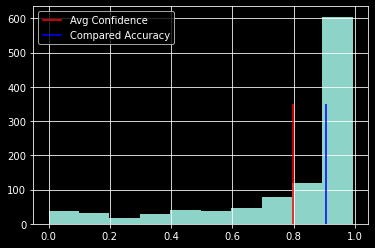

In [124]:
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=len(data[data.comp == data.prediction]) / len(data), ymin=0, ymax=350, colors='blue', label='Compared Accuracy')
# plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

In [5]:
submissions = data[['prediction']].rename(columns={'prediction':'label'})
submissions['id'] = range(1, 1+len(submissions))
submissions = submissions[['id', 'label']]
submissions.to_csv('../submissions-aug/submission-da.csv', index=False, sep='\t')

# Loss

In [9]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch, focal_loss=True):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output['logits'], axis=-1)
        if focal_loss:
            loss = binary_focal_loss(output['logits'], batch["labels"].to(device), alpha=0.3, gamma=0.8, sum=False)
        else:
            loss = cross_entropy(output['logits'], batch["labels"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
# model = BertWithNER(bert_model=model_name, ner_model=ner_model_name)
model = AutoModelWithNER(model=model_name, ner_model=ner_model_name)
state_dict = torch.load(checkpoints[0], map_location=device)
# for key in list(state_dict.keys()):
#     state_dict[key.replace('bert', 'base_model')] = state_dict.pop(key)
model.load_state_dict(state_dict)
model.cuda()

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at uer/roberta-base-finetuned-cluener2020-chinese were not used when initializi

AutoModelWithNER(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [10]:
train.dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'auxiliary_input_ids', 'labels'])
eval_outputs = train.dataset['val'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/283 [00:00<?, ?ba/s]

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display()

label                                               text
id                                                               
23495-1      1  海南“国际旅游岛”项目是我国由官方独立建造、独立规划、独立投资、独立管理、独立收支的特大型海...
39138        1                    央视“成语大会”栏目将国学娱乐化，有利于更多人研究和了解国学。
20777        1  随着反腐力度的进一步加大，新的反腐形势也在出现，有的甚至更加隐秘。反腐是一场持久的战争，它的...
30283        1  “汕优63”杂交稻近几年的年种植面积都超过1亿亩，平均亩产稳定在约500千克左右，不仅产量高...
34053        1  通过这几年的努力，使中国的水面舰艇研制水平和研制能力已经进入世界先进行列，这为中国海军执行远...
41533        1  在此次重庆市青少年科技创新大赛中，同学们常围在一起相互鼓劲并认真总结得失，赢得的远远不只是比...
15549        1         价格改革涉及利益复杂，不仅要坚持改革的方向，积极推进，而且要对方案认真周密研究部署。
42976        1      南通老百姓和海内外游客在狼山不仅可以感受到江海神韵，还可以感受到民族文化的永恒魅力之所在。
11432        1  据美国务院发言人维多利亚·纽兰9日在例行新闻发布会上表示，希望中国发挥影响力，采取措施帮助阻...
14855        1  2010年12月15日，海尔发布一款新型手机，这是一款待机功能十分突出的商务型手机，内置智能...
25522        0  出口退税增量实行中央和地方分担，是否会出现新的欠税和退税现象以及跨地区收购、出口贸易受限等问...
16300        1  我国在2010年里再次出台促进农业发展的一系列激励政策、调控政策和财政政策，极大地激发和调动...
14805        1        为解决“最后一公里”的问题，不少快递公司进行了自建门店、合作便利店、智能快递柜等方式。
39598        0  无论是提高艺术表现力，还是判断艺术的优劣高下和学术上的是非，都不靠行政命令，而要靠艰苦的艺术...
11108        0                         语文课程是一门学习语言文字运用的综合性、实践性课程。
25018        1  截至27日，利比亚反对派已经控制的黎波里绝大部分区域，但双方的战斗仍在南部市郊持续胶着。虽然...
35227        1  近日多个自媒体微信公众号发布了“缩短学制”的报道，该消息在家长群中被广泛转发传播，对此，省教...
13091        0              4月10日，铁路部门开始在全国实施新的列车运行方案，优化高铁列车开行路线。
38409        1            在新形势下，我们应该树立新的文化发展观，挖掘和推进文化体制创新和特色文化内涵。
12749        1  钱培芝提醒公众，不要轻信那些不负责任的宣传，也不要迷信巧舌如簧的推销诱惑，同时重视自我保护，...
40802        1  留学生们如果能为自己找准清晰的定位，为自己而留学，那么社会上“留学归国后找不到工作”的抱怨，...
24947        0                国务院要求加快推进宽带网络基础设施建设，进一步提速降费，提高服务水平。
28414        1   欧洲正面临十年来最严重的恐怖威胁，反恐任务十分艰巨，还需要进一步加快建立信息共享并加强情报分析。
29454        0                      为了防止此类事故再发生，本市相关部门采取了一系列安全措施。
24141        0  中东局势依然动荡，原油价格大幅上升，将对全球经济复苏产生不利影响，美国经济复苏的前景也因此蒙...
2680         1  很多同学都深切地说，自己体会到了鲁迅为了拯救国民灵魂而不惜呐喊、勇往直前的奋斗精神，以及他胸...
1066         0  学习绘画的人们都应该知道，孩子在先期学习的时候主要就是临摹，而几米的作品构图简单，线条和色彩...
12083        1  考古专家认为，山东兖州兴隆塔地宫的发掘，对古代佛教文化研究不仅有重大贡献，并且具有极高的历史...
16593        0                              通过这次活动，我们开阔了眼界，增长了知识。
3157         1           该书的出版把“名人”出书热又掀起一个高潮，同时也引来对名人出书热的更严厉的批评。
42884        0  桐城派的义法是应封建社会的政治需要而产生的，随着封建社会的逐步解体，打破桐城派义法的枷锁成为...
41437        1                      《朗读者》得到广泛好评，是因为其形式新颖、内涵丰富的缘故。
26084        1  由于存款准备金率上调，使得银行必须调整资产的配置，将资金从债券、贷款等高收益品种调整至准备金...
31929        0                               大气污染影响了农作物的播种、培育和收获。
15560        1  为进一步保障百姓餐桌安全，国家对施行已超过5年的《食品安全法》做了修订，因加大了惩处力度而被...
43020        1  有人认为在语文课堂上让学生读读武侠小说，能激发学生的阅读兴趣；也有人担心，将这些与法治精神背...
31417        1  央视请来教育部部长周济，请他就当前备受指责的高考阐述官方立场。周部长坦承民众所指出的当前高中...
41531        1  经济危机爆发之后，希腊政府面临的最大困境是如何解决失业问题，严峻的形势将巨大的挑战带给了希腊...
39273        1        天地境界又可以叫做哲学境界，因为如果通过哲学，获得对宇宙的某些了解，就能达到天地境界。
18414        0        对以中国为主的对美顺差大国而言，适当的妥协不可避免，但讨价还价和适度的斗争则是必须的。
21596        0  “才”固然重要，但如果没有一颗奉献于国家，为人民谋取福祉的心，你即使学富五车、满腹经纶，也不...
33742        0  我省出版界积极组织精品图书参展，介绍、展现本省出版界面对加入WTO的新形势，加快产业化发展的...
38394        1  11月1日，俄罗斯、伊朗和阿塞拜疆三国总统在德黑兰会面，商谈的内容之一就是加速沿里海的连通三...
6230         1        在央视的文化栏目《国家宝藏》中，通过明星守护人的讲述，使观众看到了国宝的“前世今生”。
24246        0  著名导演英达持美国绿卡，这意味着他在世界各地的收入都需要向美国国税局报税纳税，他不愿意这么做...
22848        1  华罗庚这个名字，对我国广大的学术界朋友以及青少年是非常熟悉的。他是世界第一流的数学家，他的成...
2785         0            文章在讲述每个小故事的前后常有些议论，这些议论是为了抒发作者对鲁迅的热爱之情。
43399        1             昨天有三个报社的记者来到了石家庄一中，对老师们和同学们进行了为期一天的采访。
28835        1              据报道，2019年我国新减降费超过2万亿元左右，与GDP比重超过2%左右。
17625        1                        我们要努力克服这种费力不讨好的学习方法，提高学习成绩。
18307        1  武汉邮电科学研究院近日完成超大容量光传输实验，其传输量是单模光纤最大传输量的5倍，可满足一根...
1127         1                 2010年我省大学招收的本科自费生，是自恢复高考制度以来最多的一年。
22890        0  各国政府都驱逐他，资产者都竞相诽谤他诅咒他。他对这一切毫不在意，把它们当作蛛丝一样轻轻拂去，...
1459         1  博士教育一旦以满足社会对“具有博士学位人才”的需要为目的，就必然会走向规模迅速扩大而质量急剧下滑。
32056        1   中国教育工作者对位于巴黎市中心塞纳河畔的“国立蓬皮杜文化艺术中心”的公共图书馆留下了深刻的印象。
28653        1        冬天的乌镇应该是旅游的淡季，但因为第二届互联网大会的召开，这座江南小镇变得热闹起来了。
20348        1  据审计署发布的最新数据显示，大多数领导干部能够执行中央决策部署，认真履行职责，但也有个别领导...
15086        1  中国共产党建党九十周年的庆祝活动，大大激发了全国人民炽烈的爱国热情和民族精神，为全面建设小康...
40994        1                    老头儿觉得嘴里有一股奇怪的味道